In [1]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys

Parámetros del sistema

In [57]:
w_0 = 1 # Frecuencia natural x>0
W_0 = 5 # Frecuencia natural x<0
amort = 0 # constante de amortiguamiento
f_0 = 0.125 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 150 # Numero de fonones
w = [] # frecuencia de la fuerza externa

Frecuencia natural del oscilador

In [3]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [4]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [5]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [6]:
x = np.linspace(-10,10,500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 150/150 [01:47<00:00,  1.39it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


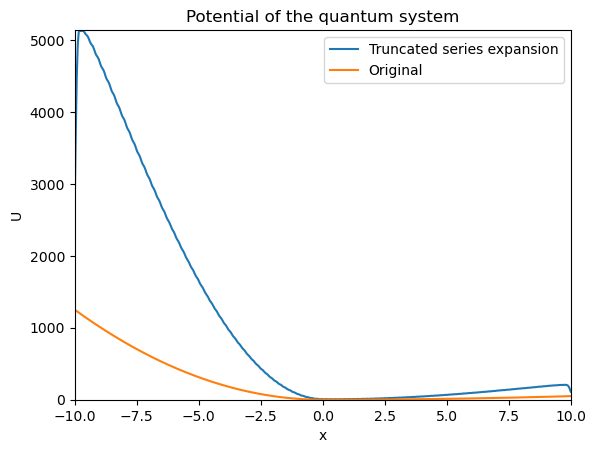

In [7]:
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([-10,10])
plt.ylim([0,np.max(U_x)])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [8]:
dt = 0.1 # Paso de tiempo
tf = 50 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [9]:
def check_state(psi):
    check = np.sum(np.diagonal(ket2dm(psi).full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [10]:
# Estado inicial:
psi0 = coherent(N,1*math.sqrt(0.5))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [43]:
def H1coeff(t,args):
    return f_0*m*np.cos(args['w']*t)

In [58]:
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
args = {'w': w[0]}
H = [H0,[H1,H1coeff]]
options = Options(store_states=True,nsteps=5000)
result = mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options,args=args)
# result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

Overlap integrals

In [59]:
O = []
O_t = []
O2 = []

for i in tqdm(range(np.size(tvec))): 
    psi = result.states[i]
    check_state(psi)
    x_exp = result.expect[0][i]
    
    psi_t = coherent(N,math.sqrt((m*w_0/2))*x_exp)
    O.append(psi.overlap(psi0))
    O_t.append(psi_t.overlap(psi))

    # psi2 = result2.states[i]
    # O2.append(psi2.overlap(psi02))

100%|██████████| 501/501 [00:13<00:00, 38.51it/s]


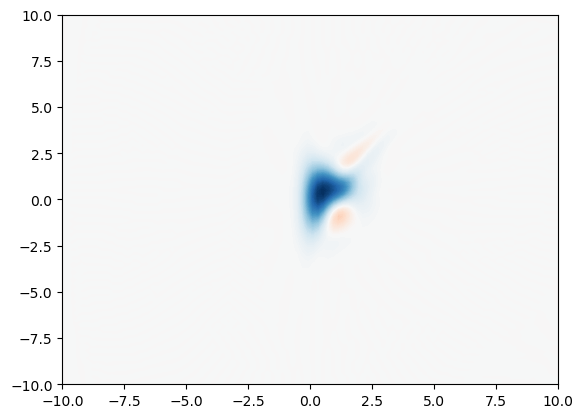

In [60]:
wig_xvec = np.linspace(-10,10,100)
wig_pvec = np.linspace(-10,10,100)
ej = wigner(psi, wig_xvec, wig_pvec)
nrm = mpl.colors.Normalize(-ej.max(), ej.max())
plt.contourf(wig_xvec, wig_pvec, ej, 100, cmap=cm.RdBu, norm =nrm)

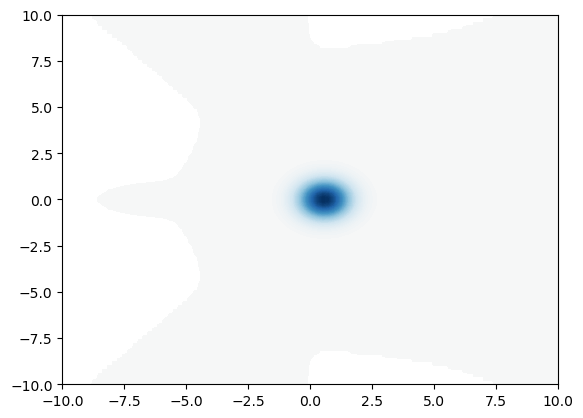

In [61]:
ej2 = wigner(psi_t, wig_xvec, wig_pvec)
nrm = mpl.colors.Normalize(-ej2.max(), ej2.max())
plt.contourf(wig_xvec, wig_pvec, ej2, 100, cmap=cm.RdBu, norm = nrm)

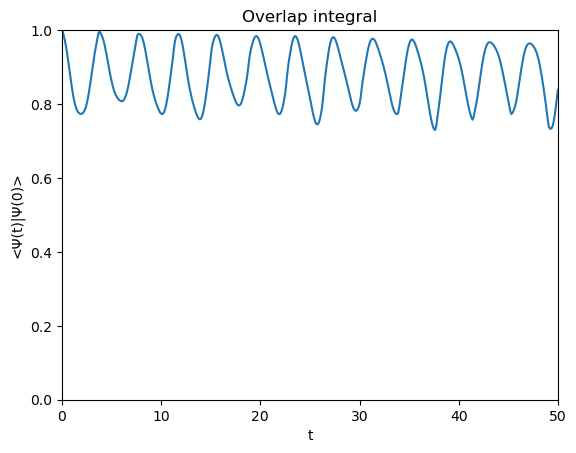

In [62]:
plt.plot(tvec,np.abs(O))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Overlap integral')
plt.xlabel('t')
plt.ylabel('<Ψ(t)|Ψ(0)>')
plt.show()

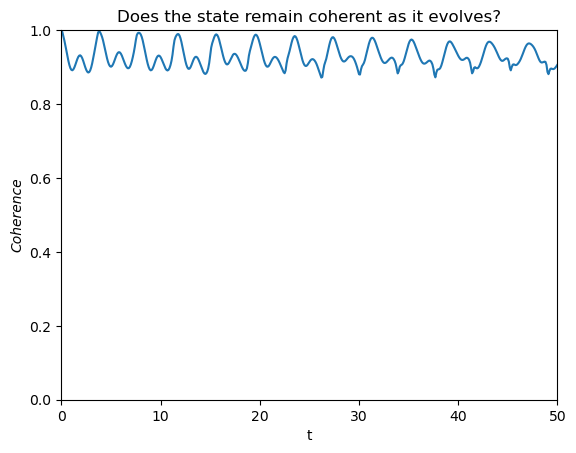

In [64]:
plt.plot(tvec,np.abs(O_t))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Does the state remain coherent as it evolves?')
plt.xlabel('t')
plt.ylabel('Coherence', style = 'italic')
plt.show()

In [65]:
fou = scipy.fft.fft(np.abs(O))
n = np.size(np.abs(O))
freq = np.fft.fftfreq(n, 0.1)[:n//2]

c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


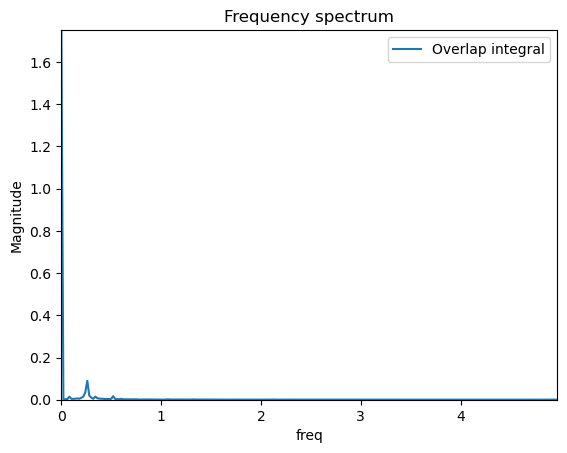

In [66]:
plt.plot(freq,(2/n)*np.abs(fou[:n//2]), label = 'Overlap integral')
plt.xlim([np.min(freq),np.max(freq)])
plt.ylim([0,max((2/n)*fou)])
plt.title('Frequency spectrum')
plt.xlabel('freq')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [67]:
desv_x = np.sqrt(result.expect[2]-result.expect[0]*result.expect[0])
desv_p = np.sqrt(result.expect[3]-result.expect[1]*result.expect[1])

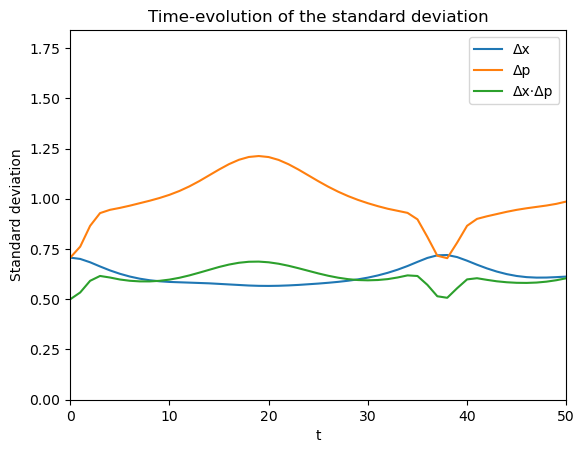

In [68]:
plt.plot(desv_x, label = 'Δx')
plt.plot(desv_p, label = 'Δp')
plt.plot(desv_x*desv_p, label = 'Δx·Δp')
plt.ylim([0,np.max(desv_p)+0.5])
plt.xlim([0,tf])
plt.title('Time-evolution of the standard deviation')
plt.xlabel('t')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

Comparación con caso clásico

In [69]:
def EDO(t,y,w):
    x,v = y
    return [v,-2*amort*v-W(x)**2*x+f_0*np.cos(w*t)]

In [74]:
pos = []
vel = []

for i in tqdm(range(np.size(w))):
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,p_0], method = 'DOP853',t_eval = tvec,args = [w[i]])
    xc,vc = sol.y
    pos.append(xc)
    vel.append(vc)

100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


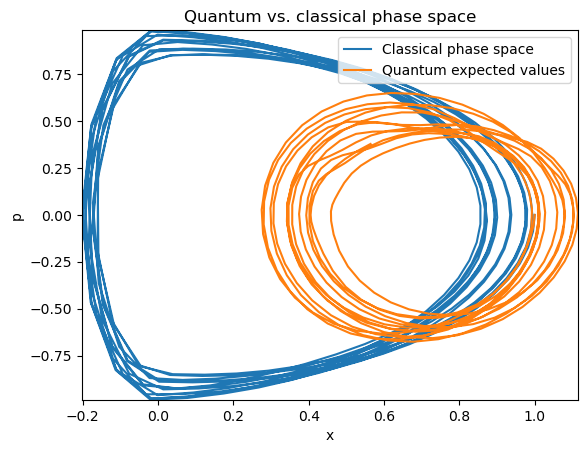

In [75]:
plt.plot(pos[0],vel[0],label='Classical phase space')
plt.plot(result.expect[0],result.expect[1],label='Quantum expected values')
plt.xlim([np.min(pos[0]),np.max(result.expect[0])])
plt.ylim([np.min(vel[0]),np.max(vel[0])])
plt.title('Quantum vs. classical phase space')
plt.xlabel('x')
plt.ylabel('p')
plt.legend()
plt.show()

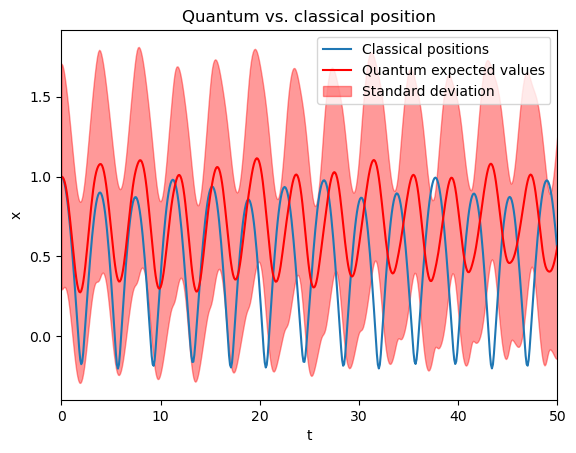

In [76]:
plt.plot(tvec,pos[0],label='Classical positions')
plt.plot(tvec,result.expect[0],label='Quantum expected values', color = 'red')
plt.fill_between(tvec,result.expect[0]-desv_x,result.expect[0]+desv_x,alpha = 0.4, color = 'red', label = 'Standard deviation')
plt.xlim([0,tf])
plt.title('Quantum vs. classical position')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

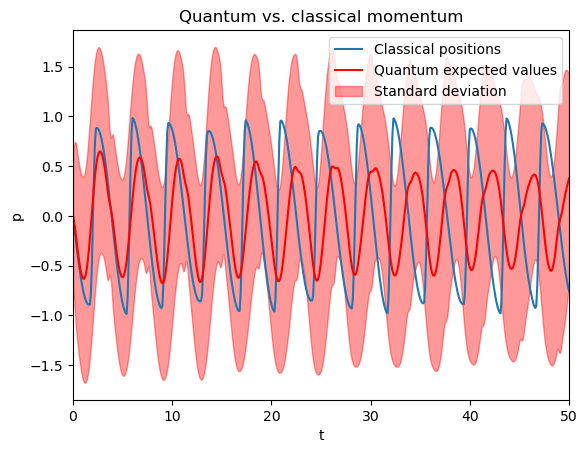

In [77]:
plt.plot(tvec,vel[0],label='Classical positions')
plt.plot(tvec,result.expect[1],label='Quantum expected values', color = 'red')
plt.fill_between(tvec,result.expect[1]-desv_p,result.expect[1]+desv_p,alpha = 0.4, color = 'red', label = 'Standard deviation')
plt.xlim([0,tf])
plt.title('Quantum vs. classical momentum')
plt.xlabel('t')
plt.ylabel('p')
plt.legend()
plt.show()

Wigner function evolution

In [26]:
Wigner = []
wig_xvec = np.linspace(-6,6,100)
wig_pvec = np.linspace(-6,6,100)
for i in tqdm(range(np.size(tvec))):   
    Wigner.append(wigner(result.states[i], wig_xvec, wig_pvec))

100%|██████████| 501/501 [14:57<00:00,  1.79s/it]


In [27]:
def update_Wigner(num,Wigner):
    plt.cla()
    wmap = wigner_cmap(Wigner[num])
    nrm = mpl.colors.Normalize(-Wigner[num].max(), Wigner[num].max())
    plt.contourf(wig_xvec, wig_pvec, Wigner[num], 100, cmap=cm.RdBu, norm=nrm)
    plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
    plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
    plt.title('Evolution of the Wigner function (t = '+str(format(tvec[num],'.3f'))+' s)')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('p')

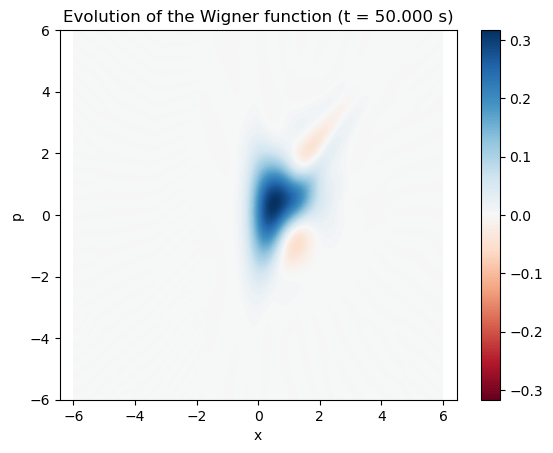

In [28]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(wig_xvec, wig_pvec, Wigner[0], 100, cmap=cm.RdBu, norm=nrm)
plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
animP = animation.FuncAnimation(imW, update_Wigner, range(np.size(tvec)), fargs = (Wigner, ), interval = 10)
animP.save('Wforz.gif')

Amount of negativity

In [29]:
neg = []
#pos = []

for i in range(np.shape(Wigner)[0]):
    neg.append(100*np.sum(((Wigner[i]<0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))
    #pos.append(100*np.sum(((Wigner[i]>=0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))

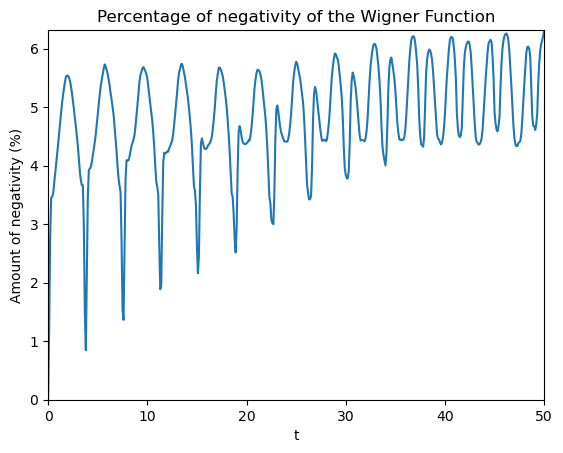

In [30]:
plt.plot(tvec,neg)
plt.xlim([0,tf])
plt.ylim([0,np.max(neg)])
plt.title('Percentage of negativity of the Wigner Function')
plt.xlabel('t')
plt.ylabel('Amount of negativity (%)')
plt.show()

Probability density

In [31]:
prob = []

for i in tqdm(range(np.size(tvec))):
    psi_x = 0
    for j in range(N):
        psi_x = psi_x + autoest(j,x,False)*result.states[i][j]
    prob.append(np.abs(psi_x)**2)

100%|██████████| 501/501 [01:55<00:00,  4.33it/s]


In [32]:
def update_prob(num,prob):
    ax1.cla()
    ax2.cla()
    ax1.plot(x, prob[num][0], label = r'$|Ψ(x)|^2$', color = 'purple')
    ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
    ax1.set_xlim([np.min(x),np.max(x)])
    ax1.set_ylim([0,1.5])
    ax2.set_ylim([0,100])
    plt.title('Evolution of probability density (t = '+str(format(tvec[num],'.3f'))+' s)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('$|Ψ(x)|^2$')
    ax2.set_ylabel('U(x)')
    plt.legend()

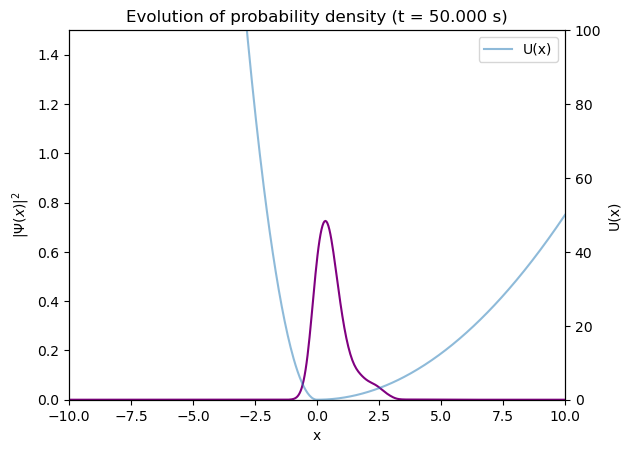

In [33]:
imP = plt.figure()
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(x, prob[0][0], label = r'$|Ψ(x)|^2$', color = 'purple')
ax2.plot(x,U(x), alpha = 0.5, label = 'U(x)')
animP = animation.FuncAnimation(imP, update_prob, range(np.size(tvec)), fargs = (prob, ), interval = 10)
animP.save('probforz.gif')

0-1 Test

Consejo: para que sea más fiable usar pasos de tiempo relativamente grandes y priorizar simulaciones a tiempos largos (> 2500 s con dt = 0.5) con varios valores de c

In [34]:
def cov(x,y):
    q = np.size(x)
    return (1/q)*np.sum((x-np.mean(x))*(y-np.mean(y)))

In [35]:
def chaos_test(O):
    
    N = np.size(O)
    N_0 = int(N/10)
    x = np.linspace(1,N,N)
    t = np.linspace(1,N_0,N_0)
    c = np.linspace(0.1,np.pi/2-0.1,50)
    K = np.zeros(np.size(c))
    E = np.mean(O)
    sigma = 0
    noise = np.random.choice(np.linspace(-0.5,0.5,N), size = N_0)
    
    for i in tqdm(range(np.size(c))):
    
        p = np.zeros(2*N)
        q = np.zeros(2*N)
        M = np.zeros(N_0)
        V = np.zeros(N_0)
        
        for n in range(1,N):
            p[n] = p[n-1] + O[n]*np.cos(c[i]*n)
            q[n] = q[n-1] + O[n]*np.sin(c[i]*n)
       
        for n in range(1,N_0):
            V[n] = E**2*((1-np.cos(n*c[i]))/(1-np.cos(c[i])))
            aux = np.zeros(N-N_0)
            for j in range(1,N-N_0):
                aux[j] = (p[n+j]-p[j])**2+(q[n+j]-q[j])**2
            M[n] = np.mean(aux)+sigma*noise[n]
        
        D = M-V
        K[i] = cov(t,D)/np.sqrt(cov(t,t)*cov(D,D))
    #plt.plot(c,K,'.')
    
    return np.median(K)

In [36]:
r = np.zeros(np.size(w))
for i in range(np.size(w)):
    r[i] = chaos_test(pos[i])
    print(r[i])

100%|██████████| 50/50 [00:02<00:00, 23.81it/s]

0.07769125345951747


In [37]:
chaos_test(np.abs(O))

100%|██████████| 50/50 [00:01<00:00, 31.71it/s]


0.18141884146415133

In [38]:
chaos_test(np.abs(O_t))

100%|██████████| 50/50 [00:01<00:00, 32.86it/s]


0.20249083511627053

C:\Users\rodri\AppData\Local\Temp\ipykernel_22684\448336455.py:3: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim([np.min(w),np.max(w)])


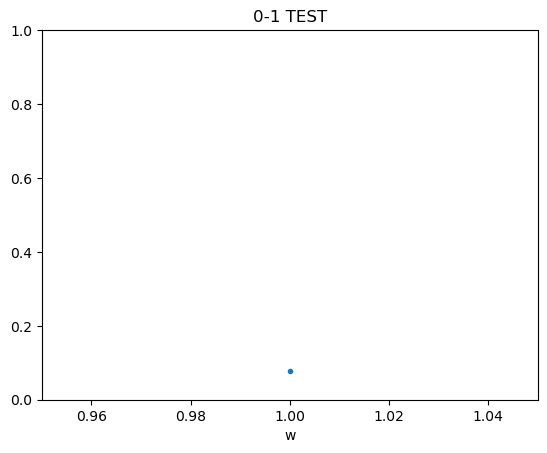

In [39]:
plt.plot(w,r,'.')
plt.ylim([0,1])
plt.xlim([np.min(w),np.max(w)])
plt.title('0-1 TEST')
plt.xlabel('w')
plt.show()

In [40]:
'''
# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #

cha = np.zeros([1000,25])
cha[0] = 0.5
coef = np.linspace(3.5,3.7,25)
for m in range(25):
    for n in range(1,1000):
        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])

r = np.zeros(25)
for i in tqdm(range(25)):
    r[i] = chaos_test(cha[:,i])

plt.plot(coef,r,'.')
plt.ylim([0,1])
'''

"\n# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #\n\ncha = np.zeros([1000,25])\ncha[0] = 0.5\ncoef = np.linspace(3.5,3.7,25)\nfor m in range(25):\n    for n in range(1,1000):\n        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])\n\nr = np.zeros(25)\nfor i in tqdm(range(25)):\n    r[i] = chaos_test(cha[:,i])\n\nplt.plot(coef,r,'.')\nplt.ylim([0,1])\n"